In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pip install tsfel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 917.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [15]:
# Import libraries
import tsfel
import glob
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score

In [16]:
#@title Data Preparation

# Load data
x_train_sig = list(np.load('/content/X_train.npy'))
x_test_sig = list(np.load('/content/X_test.npy'))
y_test = np.load('/content/y_test.npy')
y_train = np.load('/content/y_train.npy')
# activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

# dataset sampling frequency
fs = 50

In [17]:
#@title Feature Extraction
cfg_file = tsfel.get_features_by_domain()                # All features
# cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg_file = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg_file = tsfel.get_features_by_domain('spectral')    # Only spectral features

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [18]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

In [23]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(nX_train, y_train.ravel())

Accuracy: 86.11111111111111%
Displaying Confusion Matrix...


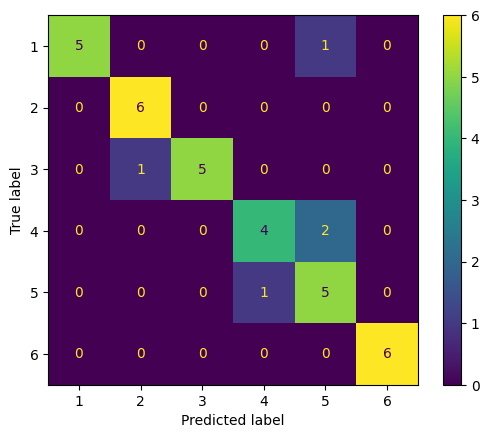

In [25]:
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
# print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + '%')
con_mat = confusion_matrix(y_test,y_test_predict, labels=classifier.classes_)
print("Displaying Confusion Matrix...")
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat,display_labels=classifier.classes_)
disp.plot()
plt.show()

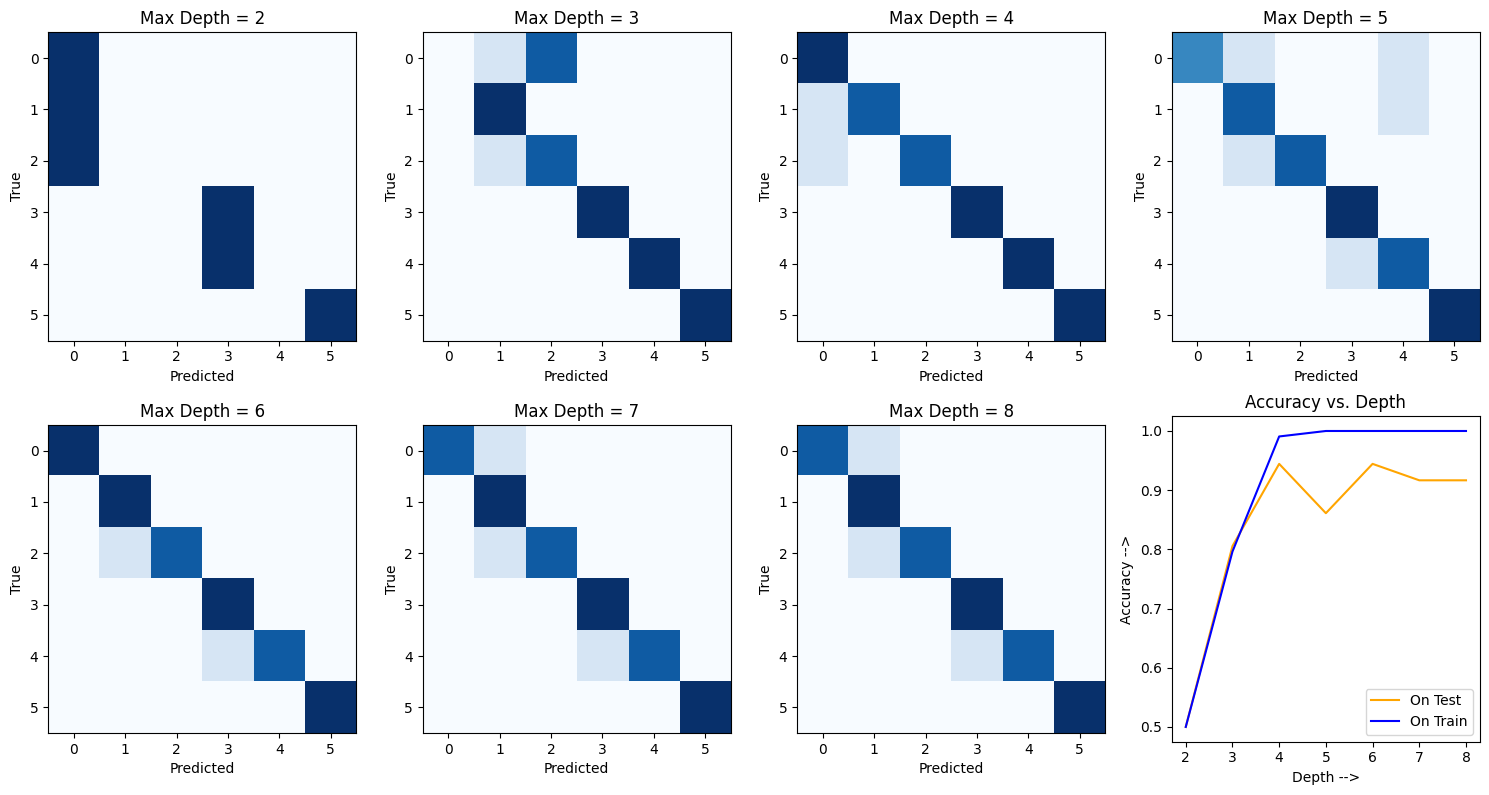

In [26]:
acc_vals = []
acc_vals_ontrain = []
con_mats = []
depths = [i for i in range(2,9)]
for depth in depths:
    Recognizer = tree.DecisionTreeClassifier(max_depth=depth)
    Recognizer = Recognizer.fit(nX_train, y_train.ravel())
    y_pred = Recognizer.predict(nX_test)
    y_pred_ontrain = Recognizer.predict(nX_train)
    acc_vals.append(accuracy_score(y_test,y_pred))
    acc_vals_ontrain.append(accuracy_score(y_train,y_pred_ontrain))
    con_mats.append(confusion_matrix(y_test,y_pred, labels=Recognizer.classes_))


# Plotting the data
num_plots = len(depths)

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# Plot confusion matrices
for i in range(num_plots):
    axs[i//4, i%4].imshow(con_mats[i], cmap='Blues', interpolation='nearest')
    axs[i//4, i%4].set_title(f"Max Depth = {depths[i]}")
    axs[i//4, i%4].set_xlabel('Predicted')
    axs[i//4, i%4].set_ylabel('True')

# Plot accuracy values
axs[1, 3].plot(depths, acc_vals, color='orange',label="On Test")
axs[1, 3].plot(depths, acc_vals_ontrain, color='blue', label="On Train")
axs[1, 3].set_title('Accuracy vs. Depth')
axs[1, 3].set_xlabel('Depth -->')
axs[1, 3].set_ylabel('Accuracy -->')
axs[1, 3].legend()
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

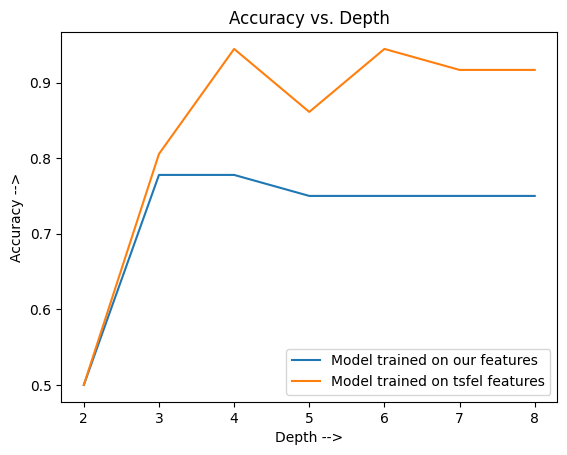

In [32]:
Q4_acc_vals = [0.5, 0.7777777777777778, 0.7777777777777778, 0.75, 0.75, 0.75, 0.75]
Q6_acc_vals = acc_vals
plt.plot(depths,Q4_acc_vals, label="Model trained on our features")
plt.plot(depths,Q6_acc_vals,label="Model trained on tsfel features")
plt.title('Accuracy vs. Depth')
plt.xlabel('Depth -->')
plt.ylabel('Accuracy -->')
plt.legend()
plt.show()


We can see in the above graph that we get better accuracies in the model trained on TSFEL features rather than using the raw data, thus we can say that featurizing does work better than using the raw data.